# MSc.Research Prototype: Contrails Detection 

##### Experiment workflow 

In is a prototype of workflow design for contrails detection experiment. Section will focus on making reproducible pipeline to experiment with data, models and training different methods.The experiment utilizes PyTorch Lightning and tensorboard for streamlined model training, logging, and evaluation.

## Experiment Overview
- **Dataset:** The experiment uses a dataset of satellite images containing contrails. The dataset is split into training and validation sets.
- **Model:** A U-Net-based architecture, referred to as `BaseUnet`, is used for image segmentation.
- **Training Workflow:** The PyTorch Lightning framework is leveraged to streamline the training workflow.



<div style="background-color: gray; padding: 10px;">
    
## Workflow Steps
    
#### 0. Getting ready 
- [x] Reproducible `GitHub` page, project files and artifacts 
- [x] Dev Env and required package testing. 
- [ ] Parameters stored in `config.py` to call at any stage of experiment.
#### 1. Data Processing
- [x] Load dataset and preprocessed using PyTorch dataset module `ContrailDataset`.
- [x] Normalize Images and add it to process for `torchvision.transform`.
- [ ] Create channels processing and bands combination output as `TensorDataset` for model input 

#### 2. Model Definition
- [x] The `BaseUnet` model is defined, specifying the input channels, output channels, and layer features.
- [ ] Model hyperparameter setting and tune
- [ ] Level-2 Models 
    
#### 3. Training Setup
- [x] The training dataset and validation dataset are defined and process to train model within PyTorch lightning .
- [x] The PyTorch Lightning `UnetLightning` module is instantiated with the baseline model, criterion, and optimizer and saving the results in Tensorboard.

#### 4. TensorBoard Logging
- [x] TensorBoardLogger tracking log experiment metrics, losses, and other visualizations.
- [x] A SummaryWriter is employed to log additional information, such as a sample image grid and the model graph.
- [ ] Model profiler info and sample image generator section 

#### 6. Model Training
- [x] The PyTorch Lightning Trainer is configured with necessary parameters, including precision, GPUs, and callbacks.
- [x] The `fit` method is called to train the model, and training progress is visualized in TensorBoard.
- [ ] Hyperparameter tuning and optimization

#### 7. Experiment Monitoring
- [x] TensorBoard is utilized to monitor and analyze the experiment's progress, including loss graphs, metrics, and visualizations.
- [x] Checkpoints are saved during training for model recovery and evaluation with `EarlyStoping` based on valid_loss.

#### 8. Results
- [ ] The experiment concludes with insights from TensorBoard visualizations, model checkpoints, and potential improvements for future experiments.
- [ ] Results of different experiment comparison and analysis.
</div>

## Step-0: Setup

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime


# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module 
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

/home/jovyan/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: R2021a is an invalid version and will not be supported in a future release
  warnings.warn(


## Get Data

In [4]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.tail()

,Image_ID,Class
11284,3816590513509902394,0
11964,3297656212779292773,0
5390,5369159359735899734,1
860,1431026080843722872,0
15795,1111066390974440788,1


In [6]:
train_df.groupby(['Class']).count()

,Image_ID
Class,
0,9001
1,7422


In [14]:
%%time
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Lambda(lambda x: utils.get_rgb(x))
])

train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:4 sequence image
                                ) 

valid_dataset = ContrailsDataset(dataframe=valid_df, 
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform, 
                                 sequence_index=config.TS
                                )
## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=config.BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=config.WORKERS, 
                              prefetch_factor=config.WORKERS
                             )

CPU times: user 443 µs, sys: 206 µs, total: 649 µs
Wall time: 663 µs


## Visualize

In [15]:
%%time
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

CPU times: user 53.5 ms, sys: 240 ms, total: 294 ms
Wall time: 725 ms


(torch.Size([4, 3, 256, 256]), torch.Size([4, 1, 256, 256]))

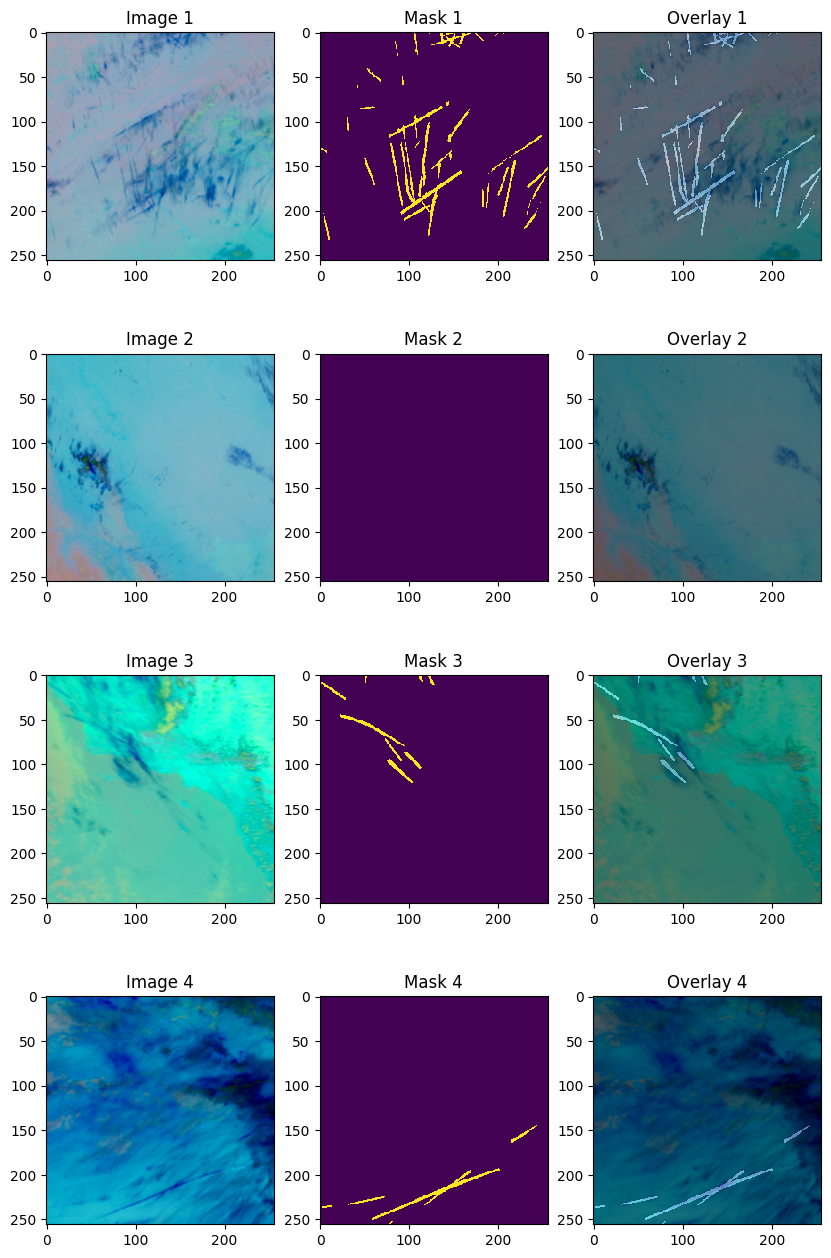

In [16]:
utils.plot_image_and_mask(image, mask)

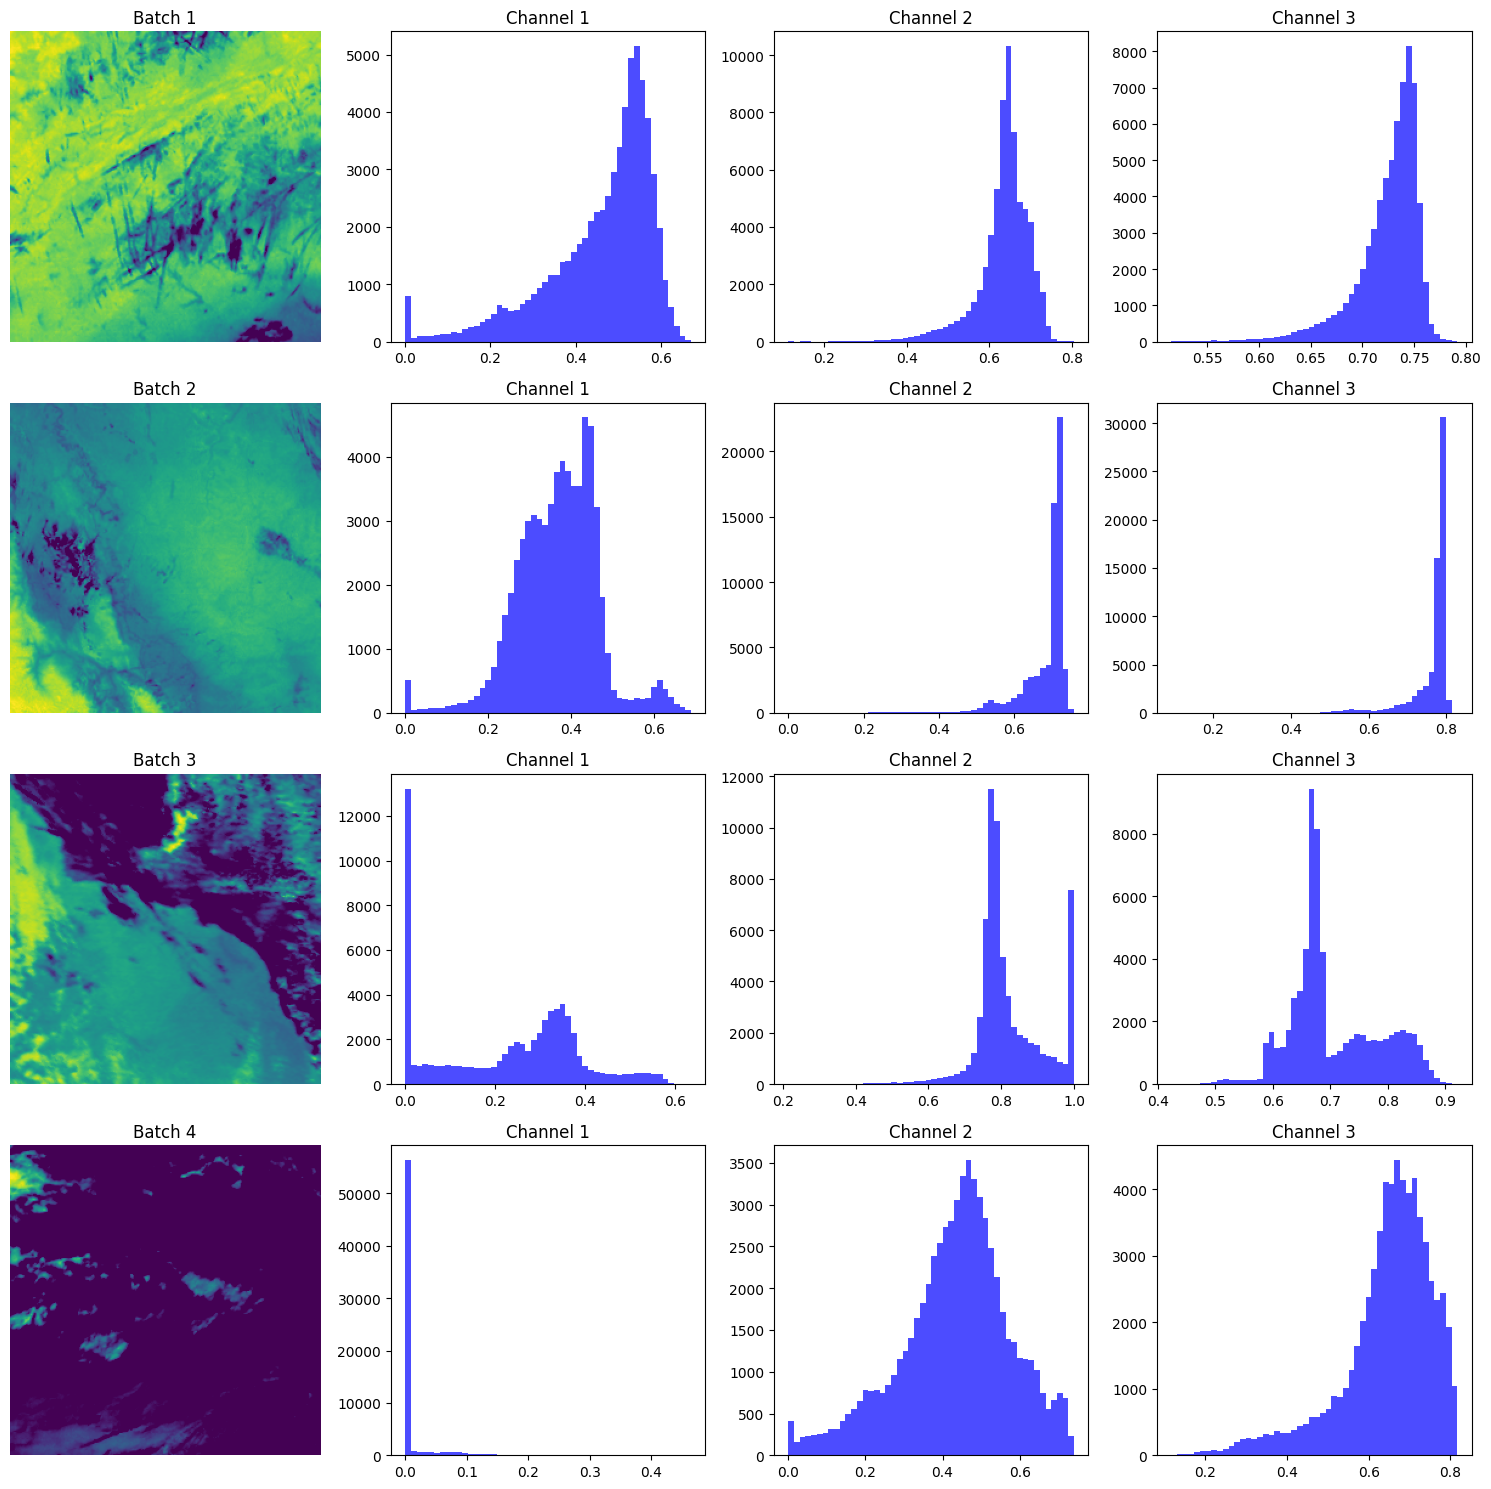

In [17]:
utils.plot_batch_histogram(image)

## Model Building

In [18]:
config.BANDS

'ALL'

In [20]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


model_tr = BaseUnet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

In [21]:
# Paths
_expr_name = config.NAME + "Norm_AshRGB"

# Tensorboard
tb_path = config.TB_PATH +"/"+ config.DEV
logger = TensorBoardLogger(tb_path, name=_expr_name)


main_model = model_tr.to(config.DEVICE)

#weights = torch.tensor([120])
criterion = torch.nn.BCEWithLogitsLoss()

# Gradient clipping to avoid exploding gradients
torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)
# Schedular
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}
# Training Model
model_tr_lgt = TrainerLightning(main_model,
                                     criterion,
                                     config.LR_RATE,
                                     train_dataset,
                                     valid_dataset,
                                     scheduler_name,
                                     scheduler_params,
                                     config.BATCH_SIZE, 
                                     config.WORKERS
                                    )

early_stop_callback = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_callback = ModelCheckpoint(
        dirpath=config.MODEL_DIR + "/" +_expr_name,
        monitor="val_loss",
        save_last=True,
        save_top_k=5
    )

print(_expr_name, image.shape[1])

baseline-unetNorm_AshRGB 3


In [24]:
trainer_lgt = pl.Trainer(
        logger=logger,
        precision=config.PRECISION,
        accelerator=config.ACCELERATOR,
        devices=[0],
        min_epochs=1,
        max_epochs=config.NUM_EPOCHS,
        callbacks=[checkpoint_callback, early_stop_callback] # 
    )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
#run trainer
torch.cuda.empty_cache()
trainer_lgt.fit(model_tr_lgt)

Missing logger folder: tb_logs/Obj1/baseline-unetNorm_AshRGB
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:272: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'patience', 'min_lr', 'factor', 'mode'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name      | Type              | Params
------------------------------------------------
0 | model     | BaseUnet          | 7.8 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.532    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

## Model prediction Results

In [6]:
image_p, mask_p = next(iter(valid_dataloader))

#### Raw All bands 

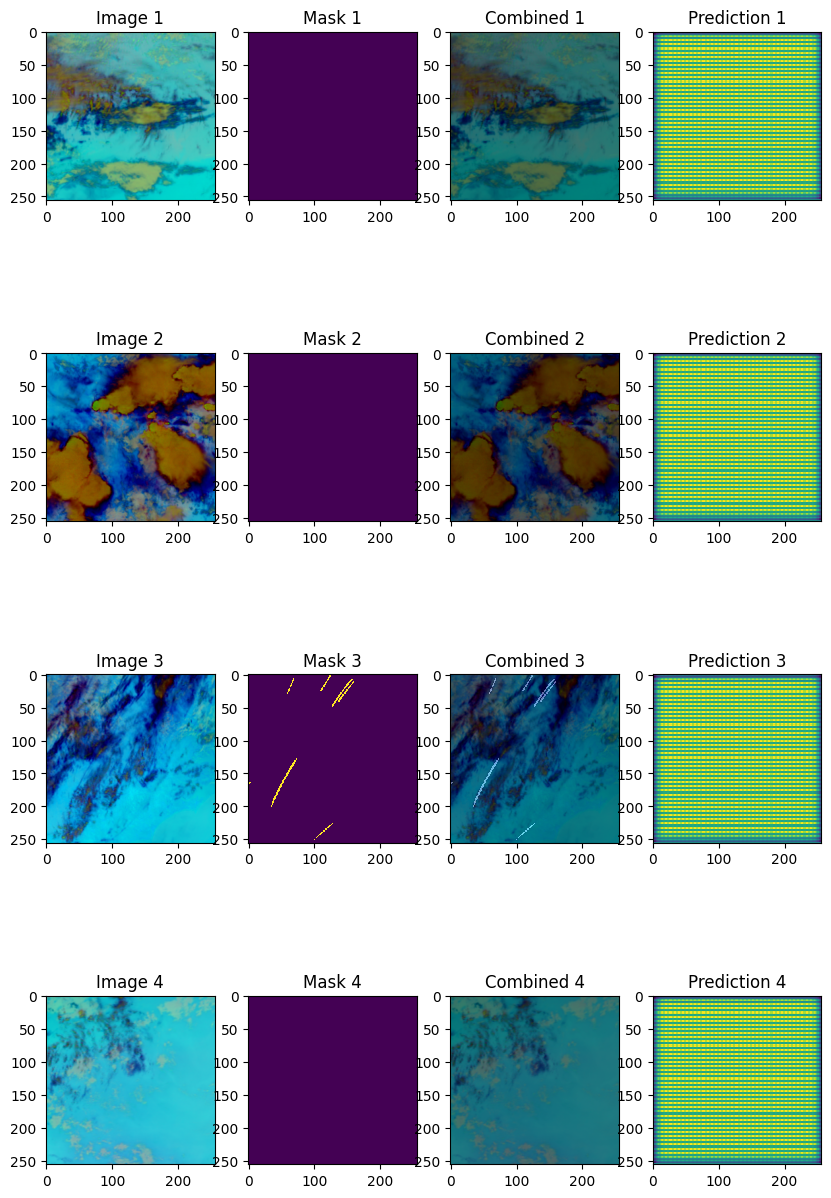

In [124]:
checkpoint_path = f"models/checkpoints/last-v4.ckpt"
checkpoint = torch.load(checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v4 = BaseUnet(in_channels=9, out_channels=1)
model_v4.load_state_dict(filtered_state_dict)
model_v4.eval()

model = model_v4.to(config.DEVICE)
data = image_p.to(config.DEVICE)
prediction = model_v4(data)

utils.plot_rgb_and_mask(image_p, mask_p, prediction.detach())

#### Normalized All bands

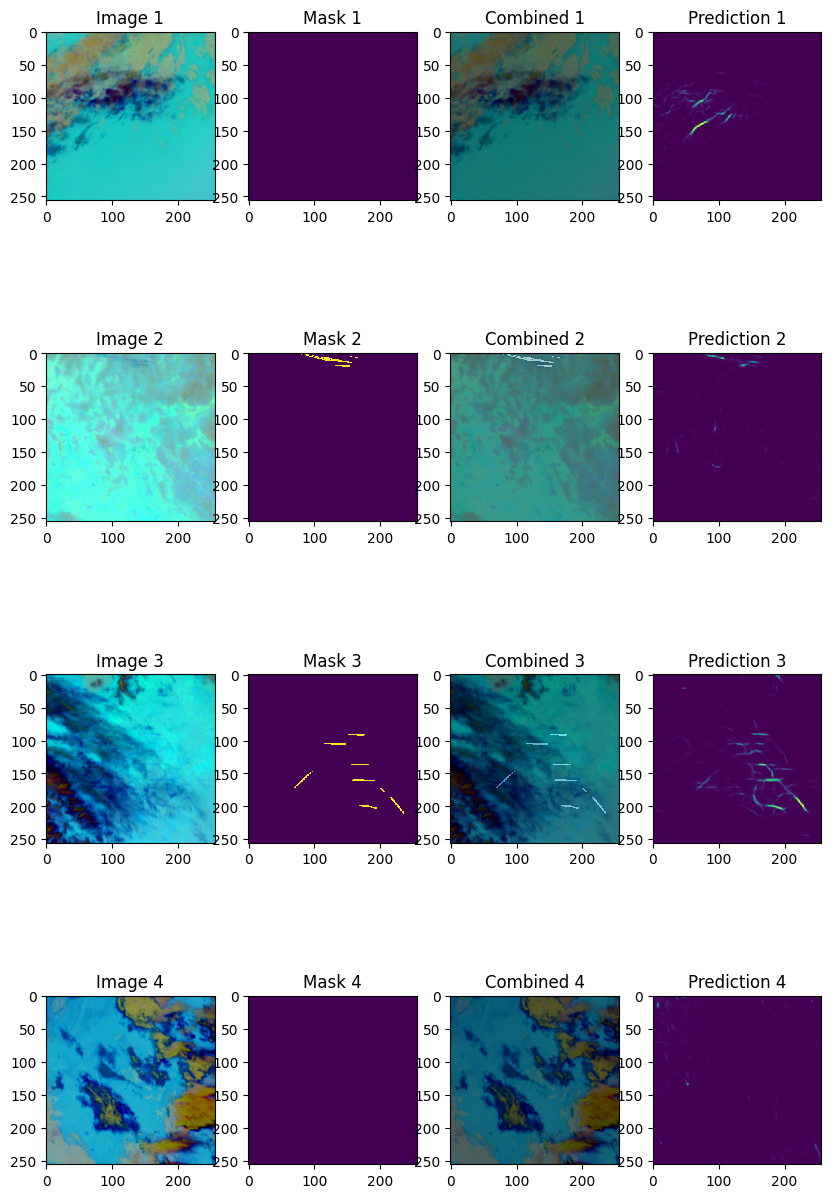

In [18]:
norm_checkpoint_path = config.MODEL_DIR +"/"+ config.DEV + "/" +_expr_name + "/last.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=9, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_p.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

utils.plot_rgb_and_mask(image_p, mask_p, prediction.detach())

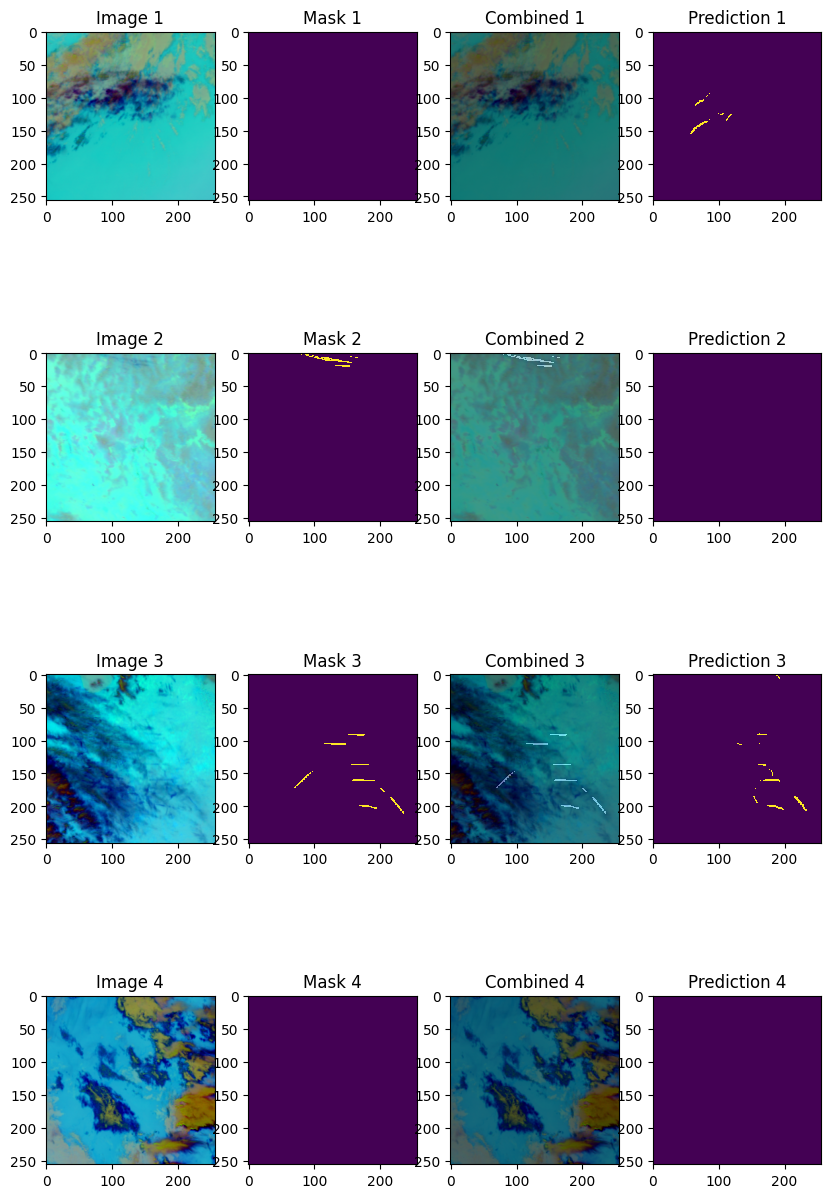

In [20]:
utils.plot_rgb_and_mask(image_p, mask_p, prediction.detach() > 0.3)

## Next Steps: (End March'2024)

- All bands and indices model training, result and summary 
- Hyperparameter tuning
- Model Architecture experiment- Increase layers, features 
- Hyperparameter tuning automation with Optune/Ray[tune]
- Finalize and make report for Baseline Prototype results and conclusion